# 📊 Proyecto: Análisis de ventas de videojuegos y planificación de campaña 2017

---
## 📖 Descripción:
Trabajé con datos abiertos de reseñas (usuarios y críticos), géneros, plataformas y ventas históricas para identificar patrones que determinan el éxito comercial de videojuegos. El objetivo fue detectar títulos y plataformas prometedoras y planificar campañas publicitarias para 2017, usando información hasta 2016 y buenas prácticas de análisis reproducible.

---

## 🎯 Objetivo: 
Identificar patrones de éxito en ventas de videojuegos usando datos hasta 2016 y planificar campañas 2017.

---
## 📂 Datos y alcance
- Fuente principal: games.csv.
- Variables clave: Name, Platform, Year_of_Release, Genre, NA_sales, EU_sales, JP_sales, Other_sales, Critic_Score, User_Score, Rating (ESRB).
- Notas: Posibles datos incompletos en 2016; se creó Total_sales sumando NA, EU, JP y Other.
- Periodo de interés: Se seleccionó según estabilidad y relevancia de plataformas (aparecen/desaparecen), distribución anual de lanzamientos y consistencia de ventas.



### Importación de librerías

In [1]:
# Cargar todas las librerías
from matplotlib import pyplot as plt
from datetime import datetime
from functools import reduce
from scipy import stats as st
import pandas as pd
import numpy as np
import math
import re

### Carga de datos

In [2]:
# Importar Dataframe 
games = pd.read_csv('games.csv')
# Información del data frame 
games.info()
# Impresión de las primeras 5 líneas iniciales del data frame
print(games.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08  

De acuerdo a los datos obtenidos de la información del la tabla de vidojuego se pueden hacer las siguientes observaciones:
+ **Renombramiento de columnas:** Los nombres de las columnas tiene que convertirse en minúsculas para que sea más fácil el manejar los comandos de Pandas para posteriores operaciones y análisis de los datos.
+ **Tratamiento de valores ausentes:** Si bien los valores ausentes que se presentan en algunas columnas podrían considerarse como insignificantes, para otras columnas representan una cantidad mucho mayor, por lo que se tiene que verificar si hay posibilidad de reemplazarlos o prescindir de ellos sin que modifiquen el análisis de todos los datos.
+ **Cambio de datos:** Una vez se haya resuelto el tema de los valores ausentes, es importante cambiar los tipos de datos de las columnas a los que corresponden, esto debibo a que eso hará más sencillo el análisis, a la par, será posible utilizar los métodos correspondientes una vez las columnas tenga su correcto tipo.

## 📄 Preparación de los datos

### Renombramiento de columnas

In [3]:
# Cambio de nombres de las columnas a minúsculas
new_name = []
for ref_column in games.columns:
    new_name.append(ref_column.lower())
games.columns = new_name
print(games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### Tratamiento de valores ausentes

In [4]:
# Verificación de valores ausentes
nan_values = games.isna().sum()
print('Cantidad de valores ausentes por columna: \n',nan_values,'\n')
# Calculo del porcentaje de representación de lo valores ausentes en las columnas
print('Porcentaje de valores ausentes por columna: \n',(nan_values/(len(games)))*100)

Cantidad de valores ausentes por columna: 
 name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64 

Porcentaje de valores ausentes por columna: 
 name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64


Para poder modificar los valores ausentes, ya sea reemplazandolos o eliminandolos, es necesario tomar en cuenta el porcentaje que representan dentro de nuestro conjunto de datos. Como se puede ver en el cálculo anterior, solo las columnas de `name` `year_of_release` y `genre` pueden ser eliminadas o modificadas, puesto que representan un porcentaje muy bajo dentro de la cantidad de datos del data frame, sin embargo, no sucede lo miscom con `critic_score` `user_score` y `rating` los cuales representan entre el 40% y 50% de los datos, el eliminar dichos datos implicaría que el conjunto ya no fuese representativo, o si se quisiera aplicar el método de reemplazar datos con la media o mediana introduciría un sesgo demasiado grande lo cual haría que cualquier análisis fuese nada fiable. A pesar de lo concluido anteriormente es necesario verificar más rasgos de los datos para poder tomar una desición. Conforme se avance en esta sección se tomarán las desiciones pertinentes acorde a lo más conveniente.

#### Columna genre

In [5]:
# Impresión de valores ausentes en la fila de género
print(games[games['genre'].isna()])
# Eliminación de las filas con valores ausentes
games = games.drop([659,14244])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


Como se puede observar en la sección anterior, es coincidente que las filas que tienen valores ausentes para la columna de `name` como para la columna de `genre` son las misma, por ende, es más sencillo eliminarlas. Para estos datos en particular es mucho mejor eliminarlos que rellenarlos, puesto que no hay mucha información que nos pueda ayudar a buscar los campos faltantes de `name` y `genre`, inclusive, tampoco hay información de `critic_score`, `user_score` y `rating`, la información restante podría coincidir con cualquier juego, así que no son datos útiles para nuestros futuros análisis.

#### Columna year_of_release

In [6]:
# Obtención de los valores únicos de los años de lanzamiento
years = pd.unique((games['year_of_release']))
print('Años de lanzamiento: \n',np.sort(years))

Años de lanzamiento: 
 [1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991.
 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003.
 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.
 2016.   nan]


In [7]:
old_games = games[games['year_of_release'] < 2000]
print('Porcentaje de valores ausentes en los datos de antes del 2000: \n', (old_games[['critic_score','user_score']].isna().sum()/games[['critic_score','user_score']].isna().sum())*100)

Porcentaje de valores ausentes en los datos de antes del 2000: 
 critic_score    21.898321
user_score      27.959397
dtype: float64


De acuerdo con lo calculado es visible que la cantidad de valores ausentes que representan los años anteriores al 2000 oscilan entren 21% y 27% del total de los datos. En un primer análisis se pensó que lo datos representarían una cantidad mucho mayor, pusto que al principio se creía que la práctica de asignar puntuaciones a los juegos se hizo popular en años proximos a los 2000, sin embargo, no es cierto pues esta práctica inicio desde los años 80. A pesar de esto, no todos los juegos tienen una reseña, ya sea por varios factores que van desde la falta de promoción o distribución, los juegos son muy pequeños o experimentales, entre otros factores.

#### Columna critic_score

In [8]:
# Filtrado por valores ausentes de la columna critic_score
critic_games = games[games['critic_score'].isna()]
print('Porcentaje de representación de los valores ausentes por cada año: \n',(critic_games.groupby('year_of_release')['name'].count()/games.groupby('year_of_release')['name'].count())*100)

Porcentaje de representación de los valores ausentes por cada año: 
 year_of_release
1980.0    100.000000
1981.0    100.000000
1982.0    100.000000
1983.0    100.000000
1984.0    100.000000
1985.0     92.857143
1986.0    100.000000
1987.0    100.000000
1988.0     93.333333
1989.0    100.000000
1990.0    100.000000
1991.0    100.000000
1992.0     97.674419
1993.0    100.000000
1994.0     99.173554
1995.0    100.000000
1996.0     96.958175
1997.0     94.117647
1998.0     92.612137
1999.0     88.461538
2000.0     59.142857
2001.0     32.365145
2002.0     24.366707
2003.0     24.516129
2004.0     26.377953
2005.0     30.244941
2006.0     38.369781
2007.0     42.188805
2008.0     49.894884
2009.0     54.347826
2010.0     60.159363
2011.0     55.985915
2012.0     50.842266
2013.0     49.816176
2014.0     55.077453
2015.0     62.871287
2016.0     53.784861
Name: name, dtype: float64


De acuerdo a la agrupación de datos que se muestra anteriormente se puede ver que desde el año 1980 hasta el 1999 los datos ausentes representan la mayoría, o bien, todos los datos representativos de esos años, por lo que la mejor opción podría ser quedarnos con los datos del año 2000 en adelante. A pesar que lo dicho anteriormente puede tener sentido, el análisi hecho en la sección anterior, arrijó que los datos solamente representan el 21% de los datos ausentes totales, los demás datos están repartidos de los años 2000 en adelante. El eliminarlos o reemplazarlos en nuestro análisis no mejoraría en gran medida el estudio posterior de los datos y estaríamos dejando de lado la información que si nos proporciona, por lo tanto, se tendría que dejar sin modificación.

#### Columna user_score

In [9]:
# Obtención de valores únicos de user_score
print(pd.unique(games['user_score']))

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


In [10]:
# Reemplazo de los valores tbd
games['user_score'] = games['user_score'].replace('tbd',-1)

De todo el conjunto de valores únicos, el que resalta es el definido como **tbd**, de acuerdo con la información obtenida, las puntuaciones **tbd** se dan cuando el juego aún no tiene una calificación, para fines prácticos se podría reemplazar por un valor numérico negativo y así poder convertir al tipo de dato correspondiente, así como, manipularlos sin problema.

#### Columna rating

In [11]:
# Obtención de los valores únicos del rating
print(pd.unique(games['rating']))

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


Dentro de los datos, la calificación de **K-A** llama la atención entre los demas. Haciendo una investigación posterior se pudo encontrar que dicha calificación fue renombrada como **E** después de 1998, por lo tanto se pueden reemplazar esos datos para su análisis posterior.

In [12]:
# Reemplazo de los valores del rating
games['rating'] = games['rating'].replace('K-A','E')
print(pd.unique(games['rating']))

['E' nan 'M' 'T' 'E10+' 'AO' 'EC' 'RP']


In [13]:
# Reemplazo de los valores ausentes para el rating
games['rating'] = games['rating'].fillna('Unknown')
rating = games.groupby('rating')['name'].count()
print('Número de juegos por rating: \n',rating)
print('Porcentaje de juegos conrating desconocido \n',(rating/len(games['rating']))*100)

Número de juegos por rating: 
 rating
AO            1
E          3993
E10+       1420
EC            8
M          1563
RP            3
T          2961
Unknown    6764
Name: name, dtype: int64
Porcentaje de juegos conrating desconocido 
 rating
AO          0.005983
E          23.891581
E10+        8.496380
EC          0.047867
M           9.352001
RP          0.017950
T          17.716747
Unknown    40.471489
Name: name, dtype: float64


Para los valores ausentes se decidió tomarlos en cuenta en vez de eliminarlos, incluso antes que rellenarlos, para que fuesen visibles, si bien, pareciera que no son importantes, a la hora de hacer la comparación con lo demás valores, se puede ver que forman casi el 41% de los datos, lo cual no puede ser imprescindible para un buen análisis.

### Conversión de datos


In [14]:
# Cambiar los tipos de datos a los correspondientes
games['year_of_release'] = games['year_of_release'].astype('Int64')

In [15]:
# Cambiar los tipos de datos a los correspondientes
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  float64
 10  rating           16713 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


Las columnas de `year_of_release` y `user_score` tuvieron que cambiarse de tipo de dato, en el primer caso los años estaban en un formato flotante lo cual no es conveniente ya que ocupa mucha memoria y además con los años no hay operaciones que hacer con las cuales se necesiten dicho tipo de dato. Por otro lado, las puntuaciones por usuario fueron convertidas a flotantes, ya que por su naturaleza es el tipo de dato que es correspondería, para esta información es más probable que se requieran hacer operaciones aritméticas por lo cual es necesario utilizar un formato numérico.

### Cálculo de ventas totales

In [17]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
print(games.head())

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score   rating  \
0     28.96      3.77         8.45          76.0         8.0        E   
1      3.58      6.81         0.77           NaN         NaN  Unknown   
2     12.76      3.79         3.29          82.0         8.3        E   
3     10.93      3.28         2.95          80.0         8.0        E   
4      8.89     10.22         1.00           NaN         NaN  Unknown   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3     

## 📈 Análisis de los datos

### Juégos lanzados anualmente

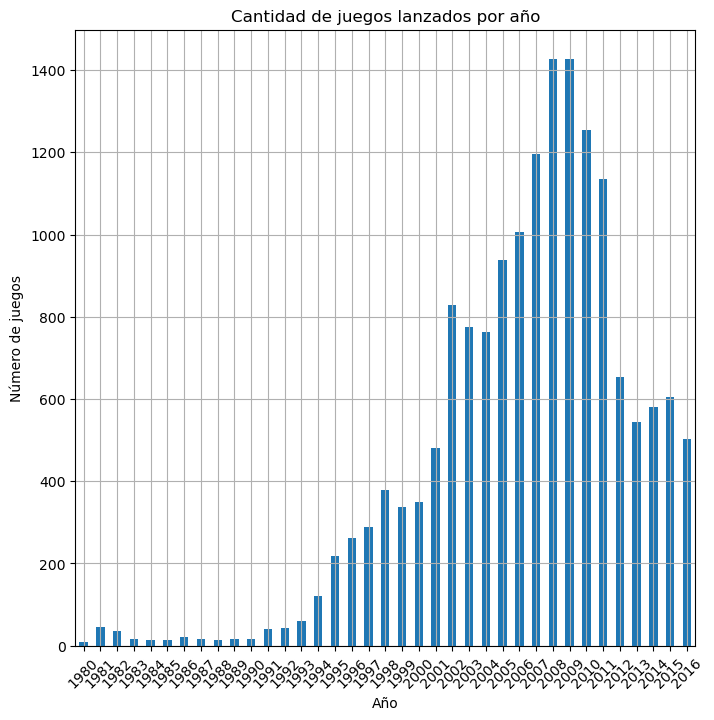

In [18]:
# Graficación de los juegos lanzados por año
games_released = games.groupby('year_of_release')['name'].count()
games_released.plot(kind='bar',
                    title='Cantidad de juegos lanzados por año',
                    xlabel='Año',
                    ylabel='Número de juegos',
                    rot=45,
                    figsize=[8,8]
                   )
plt.grid(True)
plt.show()

Con respecto a la gráfica anterior, se podría considerar que los datos comienzan a ser significativos a partir del año 1995 dónde se comienza a ver una tendencia que va en aumento, si bien los datos anteriores a esa fecha son pocos, no quiere decir que no haya más datos pues conforme pasaron los años se comenzó a generar un estandar en la industría de los videojuegos hasta convertirse en lo que es hoy. 

### Variaciones de ventas entre plataformas

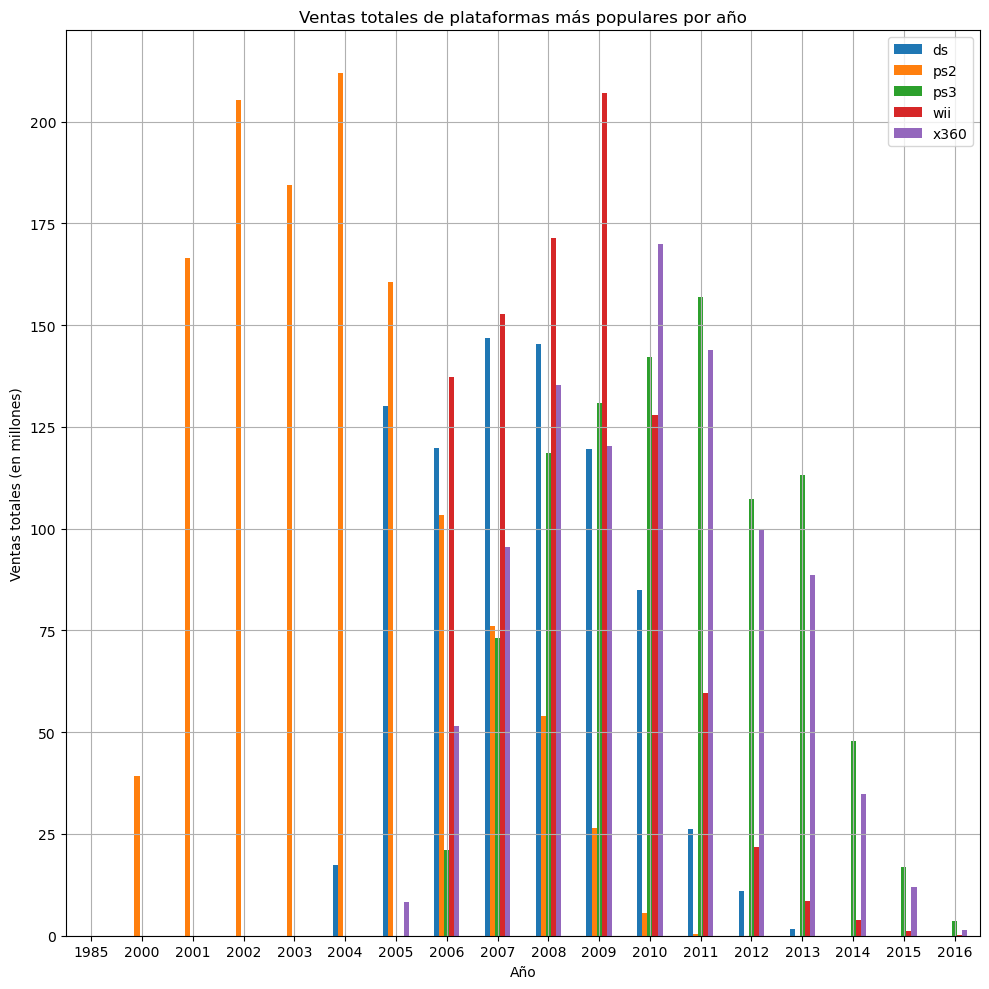

In [19]:
popular_plaftorms = games.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum').reset_index().sort_values(by=['platform','year_of_release','total_sales'],ascending=False)
platforms = ['PS2', 'X360', 'Wii', 'PS3', 'DS']
df_filter = popular_plaftorms[popular_plaftorms['platform'].isin(platforms)]
df_pivot = df_filter.pivot_table(index='year_of_release',columns='platform',values='total_sales',aggfunc='sum').fillna(0)
df_pivot = df_pivot.rename(columns={'PS2': 'total_sales_ps2','X360': 'total_sales_x360','Wii': 'total_sales_wii','PS3': 'total_sales_ps3','DS': 'total_sales_ds'})
df_pivot = df_pivot.reset_index()
console_sales = df_pivot.columns.drop('year_of_release')
df_pivot.plot(kind='bar',
              x='year_of_release',
              y=console_sales,
              title='Ventas totales de plataformas más populares por año',
              xlabel='Año',
              ylabel='Ventas totales (en millones)',
              figsize=(10,10),
              rot=0
             )
plt.grid(True)
plt.legend([col.split('_')[-1] for col in console_sales])
plt.tight_layout()
plt.show()

In [20]:
time = []
for platform in platforms:
    years = games[(games['platform'] == platform) & ~(games['year_of_release'].isna())]['year_of_release']
    time.append(len(pd.unique(years)))
print('Promedio de años de vida de consolas más populares:',sum(time)/len(time))

Promedio de años de vida de consolas más populares: 11.4


In [21]:
ps2_release = games[games['platform'] == 'PS2']['year_of_release'].min() - games[games['platform'] == 'PS']['year_of_release'].min()
ps3_release = games[games['platform'] == 'PS3']['year_of_release'].min() - games[games['platform'] == 'PS2']['year_of_release'].min()
ps4_release = games[games['platform'] == 'PS4']['year_of_release'].min() - games[games['platform'] == 'PS3']['year_of_release'].min()
print('Años que tardan las nuevas consolas en aparecer:\n','PS2:',ps2_release,'\n','PS3:',ps3_release,'\n','PS4:',ps4_release)


Años que tardan las nuevas consolas en aparecer:
 PS2: 6 
 PS3: 6 
 PS4: 7


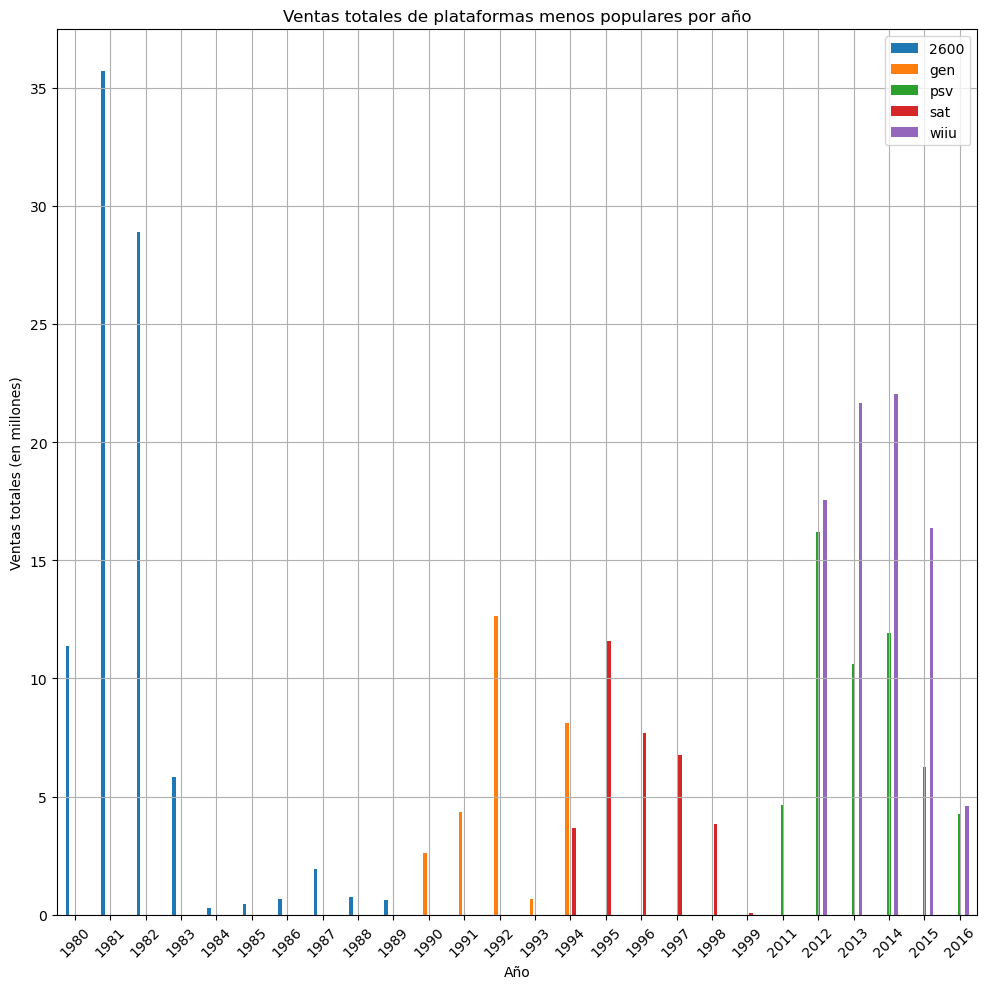

In [22]:
lpopular_plaftorms = games.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum').reset_index().sort_values(by=['platform','year_of_release'],ascending=True)
platforms_lp = ['2600', 'GEN', 'SAT', 'PSV', 'WiiU']
df_filter = lpopular_plaftorms[lpopular_plaftorms['platform'].isin(platforms_lp)]
df_pivot = df_filter.pivot_table(index='year_of_release',columns='platform',values='total_sales',aggfunc='sum').fillna(0)
df_pivot = df_pivot.rename(columns={'2600': 'total_sales_2600','GEN': 'total_sales_gen','SAT': 'total_sales_sat','PSV': 'total_sales_psv','WiiU': 'total_sales_wiiu'})
df_pivot = df_pivot.reset_index()
console_sales = df_pivot.columns.drop('year_of_release')
df_pivot.plot(kind='bar',
              x='year_of_release',
              y=console_sales,
              title='Ventas totales de plataformas menos populares por año',
              xlabel='Año',
              ylabel='Ventas totales (en millones)',
              figsize=(10,10),
              rot=45
             )
plt.grid(True)
plt.legend([col.split('_')[-1] for col in console_sales])
plt.tight_layout()
plt.show()

In [23]:
time_lp = []
for platform in platforms_lp:
    years_lp = games[(games['platform'] == platform) & ~(games['year_of_release'].isna())]['year_of_release']
    time_lp.append(len(pd.unique(years_lp)))
print('Promedio de años de vida de consolas menos populares:',sum(time_lp)/len(time_lp))

Promedio de años de vida de consolas menos populares: 6.4


Con en análisis hecho anteriormente, se puede decir que las consolas populares tardan aproximadamente 11 años en desaparecer, mientras que las menos populares tiene un tiempo de 6 años. Por otro lado, el tiempo en el que las consolas tardan en aparecer varía mucho puesto que el mercado se va ajustando a las tendencias que marcan diferentes juegos y empresas, así como también el tipo de consolas, haciendo un cálculo rápido entre las apariciones de las consolas de Sony, el tiempo promedio fue de 6 años entre consola.  Si bien el dato puede parecer contundente, aún hay que analizar otros factores que afectan en las ventas como la piratería, la popularidad de los juegos de cada plataforma, su costo, entre otros factores. 

### Filtrado de datos

In [24]:
recent_games = games[games['year_of_release'] > 1999]
print(recent_games.head())
print(pd.unique(recent_games['platform']))

                    name platform  year_of_release     genre  na_sales  \
0             Wii Sports      Wii             2006    Sports     41.36   
2         Mario Kart Wii      Wii             2008    Racing     15.68   
3      Wii Sports Resort      Wii             2009    Sports     15.61   
6  New Super Mario Bros.       DS             2006  Platform     11.28   
7               Wii Play      Wii             2006      Misc     13.96   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     28.96      3.77         8.45          76.0         8.0      E   
2     12.76      3.79         3.29          82.0         8.3      E   
3     10.93      3.28         2.95          80.0         8.0      E   
6      9.14      6.50         2.88          89.0         8.5      E   
7      9.18      2.93         2.84          58.0         6.6      E   

   total_sales  
0        82.54  
2        35.52  
3        32.77  
6        29.80  
7        28.91  
['Wii' 'DS' 'X360' 'PS3' '

### Rentabilidad de las plataformas

platform  year_of_release     PS2    X360     Wii     PS3      DS
0                    2000   39.17    0.00    0.00    0.00    0.00
1                    2001  166.43    0.00    0.00    0.00    0.00
2                    2002  205.38    0.00    0.00    0.00    0.00
3                    2003  184.31    0.00    0.00    0.00    0.00
4                    2004  211.81    0.00    0.00    0.00   17.27
5                    2005  160.66    8.25    0.00    0.00  130.14
6                    2006  103.42   51.62  137.15   20.96  119.81
7                    2007   75.99   95.41  152.77   73.19  146.94
8                    2008   53.90  135.26  171.32  118.52  145.31
9                    2009   26.40  120.29  206.97  130.93  119.54
10                   2010    5.64  170.03  127.95  142.17   85.02
11                   2011    0.45  143.84   59.65  156.78   26.18
12                   2012    0.00   99.74   21.71  107.36   11.01
13                   2013    0.00   88.58    8.59  113.25    1.54
14        

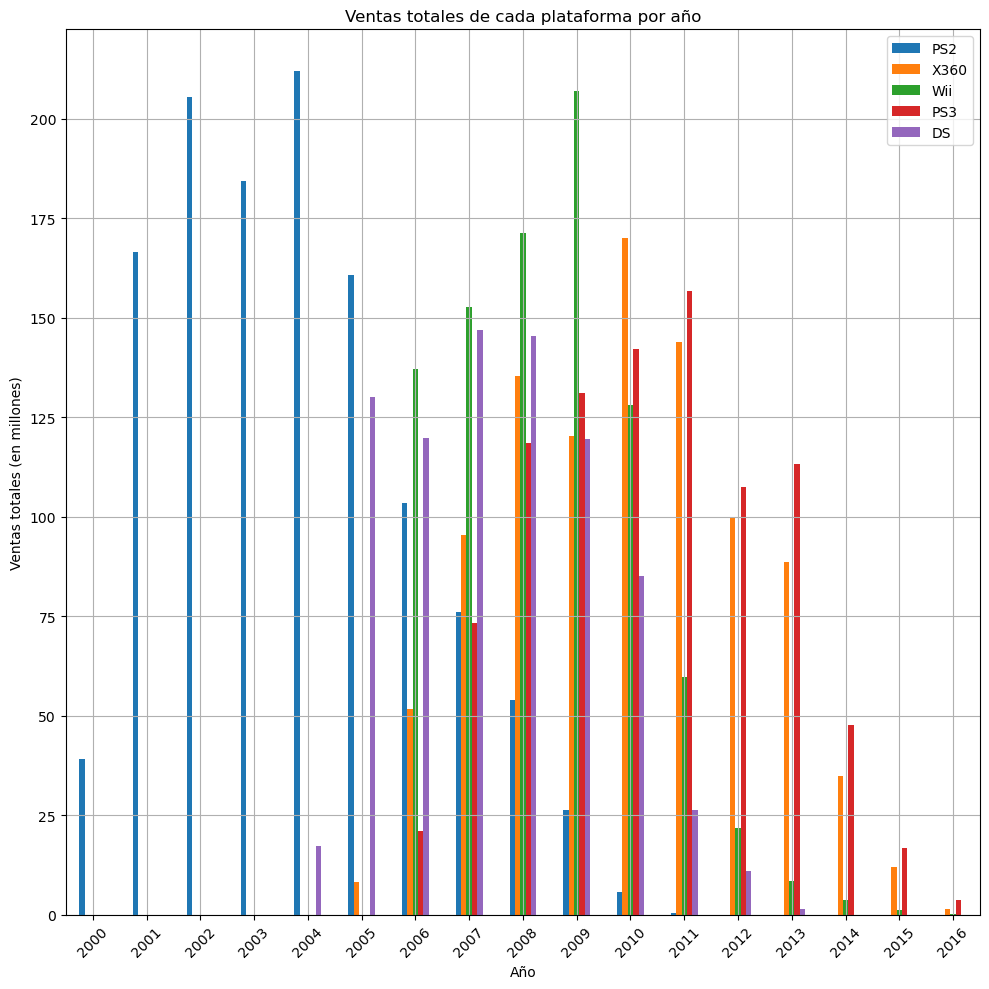

In [25]:
best_sales = recent_games.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').fillna(0).reset_index().sort_values(by='year_of_release')
best_sales = best_sales[['year_of_release','PS2', 'X360', 'Wii', 'PS3', 'DS']]
print(best_sales)
best_sales.plot(kind='bar',
              x='year_of_release',
              y=platforms,
              title='Ventas totales de cada plataforma por año',
              xlabel='Año',
              ylabel='Ventas totales (en millones)',
              figsize=(10,10),
              rot=45
             )
plt.grid(True)
plt.legend([col.split('_')[-1] for col in platforms])
plt.tight_layout()
plt.show()

Para las plataformas que comprenden del año 2000 al 2016 se puede ver que predominan las siguientes:
+ PlayStation 2
+ Xbox 360
+ Wii
+ PlayStation 3
+ Nintendo DS

A pesar de que las 5 plataformas son las que mejores ventas tienen, se puede ver que algunas se reducen mientras que otras crecen, el ejemplo más claro es la consola PS2 que empieza a decrecer en ventas mientras que las demás consolas, comienzan su crecimiento. Dentro de las plataformas más rentables encontramos la ***PS2***, ***Xbox360*** y ***Wii***, las cuáles mantuviero ventas por poco más de 10 años.

### Ventas globales por plataforma

Media de ventas en GB: 1.0740740740740742
Media de ventas en PS4: 0.8013775510204081
Media de ventas en X360: 0.7802272727272729
Media de ventas en PS3: 0.71312404287902
Media de ventas en Wii: 0.6929860031104199
Media de ventas en XOne: 0.6450202429149797
Media de ventas en PS2: 0.5799529854254819
Media de ventas en WiiU: 0.5591156462585034
Media de ventas en N64: 0.5328571428571428
Media de ventas en PS: 0.5135036496350366
Media de ventas en 3DS: 0.50353515625
Media de ventas en GBA: 0.38579531442663373
Media de ventas en DS: 0.37866037735849056
Media de ventas en GC: 0.362970479704797
Media de ventas en XB: 0.3132876712328767
Media de ventas en PSP: 0.24269069572506288
Media de ventas en WS: 0.24000000000000002
Media de ventas en DC: 0.2390322580645161
Media de ventas en PC: 0.224340239912759
Media de ventas en PSV: 0.12543123543123544


C:\Users\guita\AppData\Local\Temp\ipykernel_27108\2183200709.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sales_by_platform, labels=platforms)


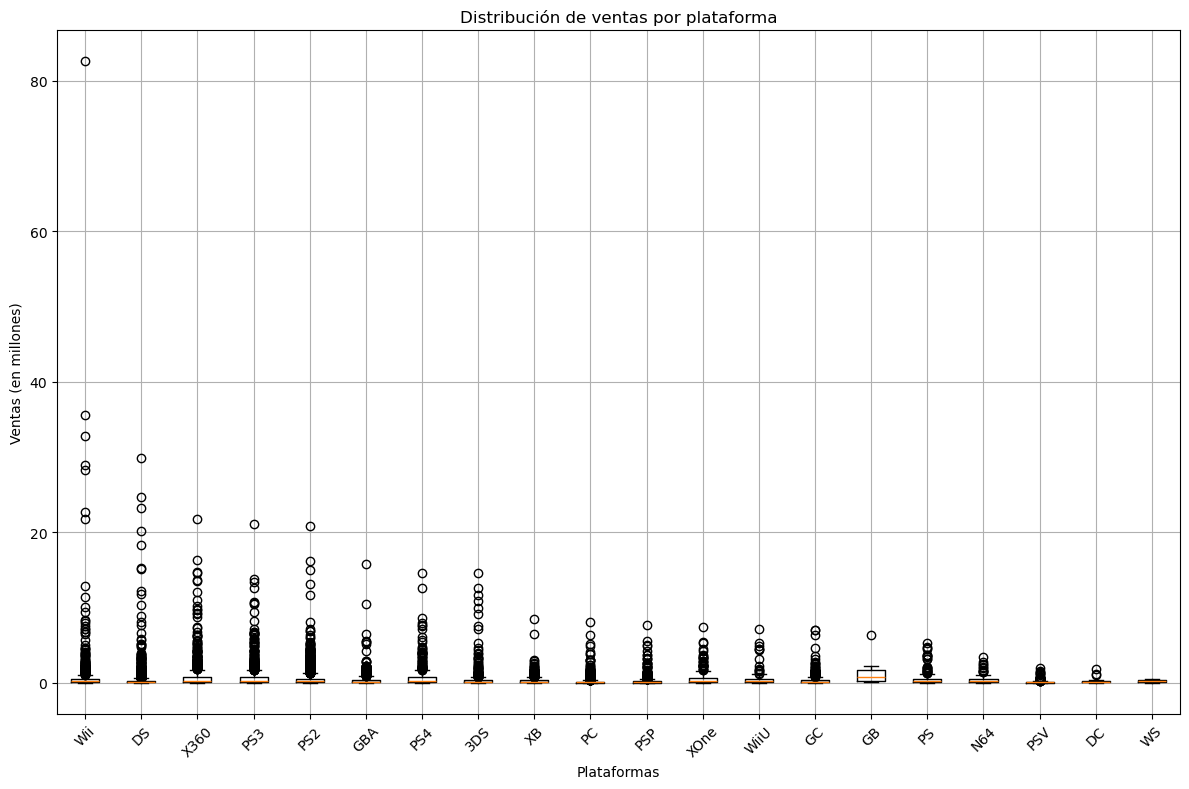

In [44]:
platforms = recent_games['platform'].unique()
sales_by_platform = []
sales_means = {}
for p in platforms:
    ventas = recent_games.loc[recent_games['platform'] == p, 'total_sales']
    sales_by_platform.append(ventas)
    sales_means[p] = ventas.mean()

for p, m in sorted(sales_means.items(), key=lambda x: x[1], reverse=True):
    print(f'Media de ventas en {p}: {m:}')
    
plt.figure(figsize=(12, 8))
plt.boxplot(sales_by_platform, labels=platforms)

plt.title("Distribución de ventas por plataforma")
plt.xlabel("Plataformas")
plt.ylabel("Ventas (en millones)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

Como lo muestra el diagrama de caja de cada una de las ventas de las plataformas se puede ver que para las plataformas desde el Wii hasta la 3DS en algunos casos las diferencias en las ventas son significativas, para otras las ventas son bastante similares, por ejemplo, plataformas como el ***PS3***, ***Xbox360*** y ***Wii***, tienen una media de ventas bastante similar, solamente diferenciandose por unos cuantos millones en ventas, pero si comparamos las ventas de un ***GB*** contra una Wii, verémos que la primera tuvo muchísimo más ventas puesto que su media es mayor. En cuanto a las medias de ciertas consolas, se puede observar que van en grupos, si bien los diagramas de cajas nos pueden dar bastante información, debido a la naturaleza de los datos, pueden ser engañosos, por lo tanto se tomó la desición de imprimir los valores de cada media de ventas por plataforma, ahí es dónde se puede ver que hay ciertos grupos de consolas que mantienen una tendencia a la alta, y otras que fueron menos populares se posicionan con las más antiguas. Si bien es una manera de determinar el comportamiento de la ventas dentro de cada plataforma, hay que considerar los valores atípicos pues estos pueden afectar la media, en análisis pasados la consola ***PS2*** se encontraba como la de mayor venta, sin embargo, en el presente análisis el el promedio de las ventas del ***GB*** es el mayor de todo, pero esto no signifique se que sea la consola más vendida.

### Correlación de ventas contra puntaciones

In [27]:
ps2_score = games[~(games['critic_score'].isna()) & ~(games['user_score'].isna()) & (games['year_of_release'] > 1999) & (games['platform'] == 'PS2')].copy()
ps2_score['user_score'] = (ps2_score['user_score'] - ps2_score['user_score'].min()) / (ps2_score['user_score'].max() - ps2_score['user_score'].min())
ps2_score['critic_score'] = (ps2_score['critic_score'] - ps2_score['critic_score'].min()) / (ps2_score['critic_score'].max() - ps2_score['critic_score'].min())
ps2_score['total_sales'] = (ps2_score['total_sales'] - ps2_score['total_sales'].min()) / (ps2_score['total_sales'].max() - ps2_score['total_sales'].min())
print(ps2_score[['critic_score', 'user_score', 'total_sales']].corr())

              critic_score  user_score  total_sales
critic_score      1.000000    0.382398     0.392536
user_score        0.382398    1.000000     0.185800
total_sales       0.392536    0.185800     1.000000


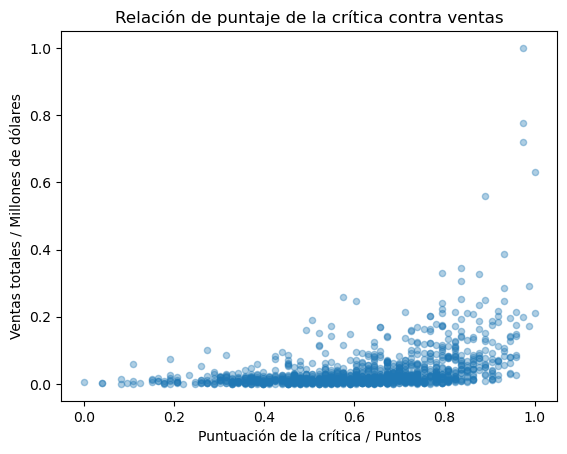

In [28]:
ps2_score.plot(x='critic_score',y='total_sales',kind='scatter',title='Relación de puntaje de la crítica contra ventas',alpha=0.36,xlabel='Puntuación de la crítica / Puntos',ylabel='Ventas totales / Millones de dólares')
plt.show()

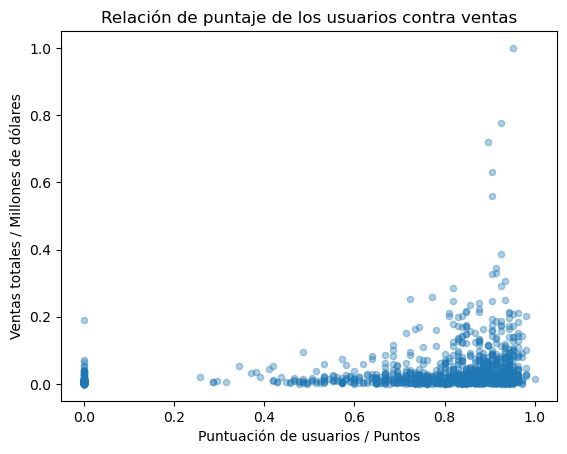

In [29]:
ps2_score.plot(x='user_score',y='total_sales',kind='scatter',title='Relación de puntaje de los usuarios contra ventas',alpha=0.36,xlabel='Puntuación de usuarios / Puntos',ylabel='Ventas totales / Millones de dólares')
plt.show()

Si bien pareciera que las ventas de una plataforma están estrechamente relacionadas con su puntuación, si bien es cierto que la puntuación influye en la popularidad y por ende en las ventas, no es un factor determinante del todo, dentro de las ventas tambíen existen otros factores que pueden afectar positiva o negativamente las ventas aunque el juego tenga una calificación alta. Como anteriormente se comentó dichos factores externos pueden ser desde piratería, hasta mala reputación de parte de las empresas o desarrolladores. Para estas variables en específico es claro que no existe una correlación fuerte.

### Ventas para juegos multiplataforma

In [30]:
mplatform_games = games[(games['name'].isin(ps2_score['name'])) & (games['year_of_release'] > 1999)]
print(np.unique(mplatform_games['platform']))

['3DS' 'DC' 'DS' 'GB' 'GBA' 'GC' 'N64' 'PC' 'PS' 'PS2' 'PS3' 'PS4' 'PSP'
 'PSV' 'Wii' 'WiiU' 'X360' 'XB']


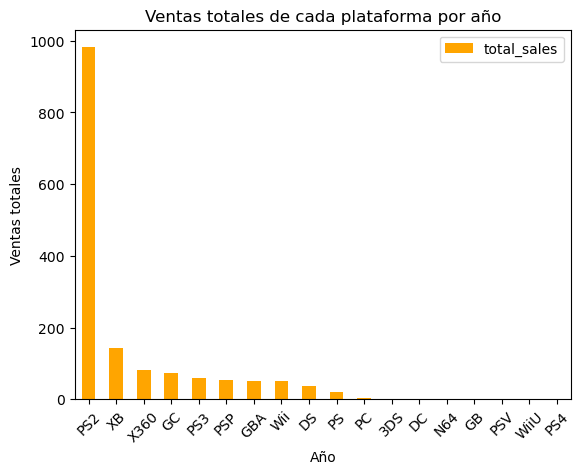

In [31]:
mplatform_games = mplatform_games.pivot_table(index='platform',values='total_sales',aggfunc='sum').reset_index().sort_values(by='total_sales',ascending=False)
mplatform_games.plot(kind='bar',
                    x='platform',
                    y='total_sales',
                    title='Ventas totales de cada plataforma por año',
                    xlabel='Año',
                    ylabel='Ventas totales',
                    color='orange',
                    rot=45
                   )

plt.show()

### Ventas de videojuegos por genero

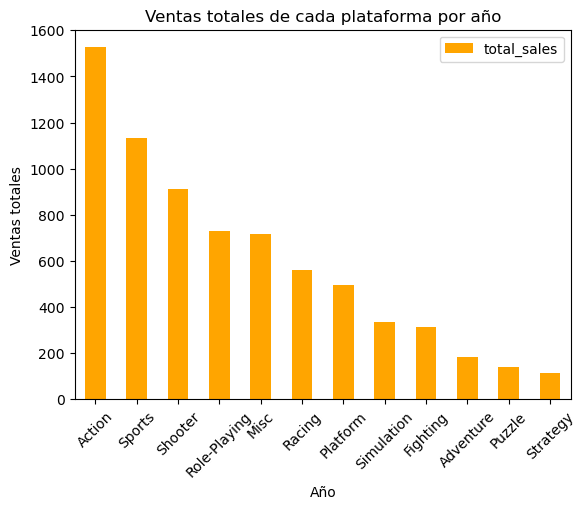

           genre  total_sales  percentage_sales
0         Action      1526.16         21.317615
10        Sports      1130.92         15.796847
8        Shooter       912.70         12.748720
7   Role-Playing       731.22         10.213782
3           Misc       718.35         10.034012
6         Racing       561.06          7.836964
4       Platform       494.42          6.906127
9     Simulation       335.41          4.685053
2       Fighting       311.90          4.356662
1      Adventure       183.74          2.566506
5         Puzzle       138.20          1.930397
11      Strategy       115.07          1.607314


In [32]:
genre_games = recent_games.pivot_table(index='genre',values='total_sales',aggfunc='sum').reset_index().sort_values(by='total_sales',ascending=False)
genre_games.plot(kind='bar',
                    x='genre',
                    y='total_sales',
                    title='Ventas totales de cada plataforma por año',
                    xlabel='Año',
                    ylabel='Ventas totales',
                    color='orange',
                    rot=45
                   )

plt.show()
genre_games['percentage_sales'] = (genre_games['total_sales']/genre_games['total_sales'].sum())*100
print(genre_games)

Entre los géneros más rentables se encuentra el género de Acción, Deportes, y Disparos, entre ellos representan casi el 50% de todos los juegos con más ventas. Para está ocasión en específico se puede decir que es una buena aproximación que ya está representando la tendencia de las preferencias del 2000 al 2016.

## 👤 Creación de perfiles de usuarios

### Plataformas principales

In [33]:
platforms_total = []
for sales in ['na_sales','eu_sales','jp_sales']:
    df_total = recent_games.groupby('platform')[sales].sum().reset_index()
    df_total = df_total.sort_values(by=sales, ascending=False).head()
    platforms_total.append(df_total)

# Usamos functools.reduce para hacer merge sucesivos
total = reduce(lambda left, right: pd.merge(left, right, on='platform', how='outer'), platforms_total)
total = total.fillna(0)
total['total_top5'] = (total['na_sales'] + total['eu_sales'] + total['jp_sales'])
total['na_sales'] = (total['na_sales'] / total['total_top5'])*100
total['eu_sales'] = (total['eu_sales'] / total['total_top5'])*100

total['jp_sales'] = (total['jp_sales'] / total['total_top5'])*100
print('Representación en porcentaje de las ventas por plataforma en cada región:\n',total.head(7))

Representación en porcentaje de las ventas por plataforma en cada región:
   platform   na_sales   eu_sales    jp_sales  total_top5
0      3DS   0.000000   0.000000  100.000000      100.62
1       DS  51.136180  25.333459   23.530361      743.72
2      PS2  54.925270  31.888907   13.185823     1043.09
3      PS3  48.965171  41.068089    9.966740      796.75
4      PSP   0.000000   0.000000  100.000000       75.88
5      Wii  65.335015  34.664985    0.000000      745.19
6     X360  68.946601  31.053399    0.000000      864.06


### Géneros principales

In [34]:
top_generos = {}
for sales in ['na_sales', 'eu_sales', 'jp_sales']:
    genre_top = (recent_games.groupby('genre')[sales].sum().sort_values(ascending=False).head().index.tolist()) 
    top_generos[f'genre_{sales}'] = genre_top
df_top = pd.DataFrame({region: pd.Series(generos) for region, generos in top_generos.items()})
print('Principales plataformas por región:\n',df_top)


Principales plataformas por región:
   genre_na_sales genre_eu_sales genre_jp_sales
0         Action         Action   Role-Playing
1         Sports         Sports         Action
2        Shooter        Shooter           Misc
3           Misc           Misc         Sports
4   Role-Playing         Racing       Platform


Se puede observer que la preferencia de géneros entre la región de Norte América y Europa es prácticamente idéntica, salvo por los generos de Role-Playing y Racing que no compartene en común. Por parte de la región de Japón, es evidente que los gustos y popularidad de los generos va a cambiar considerablemente, por cuestiones culturales y sociales, e incluso económicas.

### Afectación del ESRB en ventas

In [35]:
sales_by_rating = recent_games.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().reset_index().sort_values(by=['na_sales', 'eu_sales', 'jp_sales'],ascending=False)
print('Ventas por calificación en cada región: \n',sales_by_rating)

Ventas por calificación en cada región: 
     rating  na_sales  eu_sales  jp_sales
1        E   1249.26    690.61    189.91
4        M    727.80    472.40     57.84
6        T    709.86    392.71    131.01
7  Unknown    494.40    345.81    396.86
2     E10+    345.50    183.33     40.20
3       EC      1.53      0.11      0.00
0       AO      1.26      0.61      0.00
5       RP      0.00      0.03      0.00


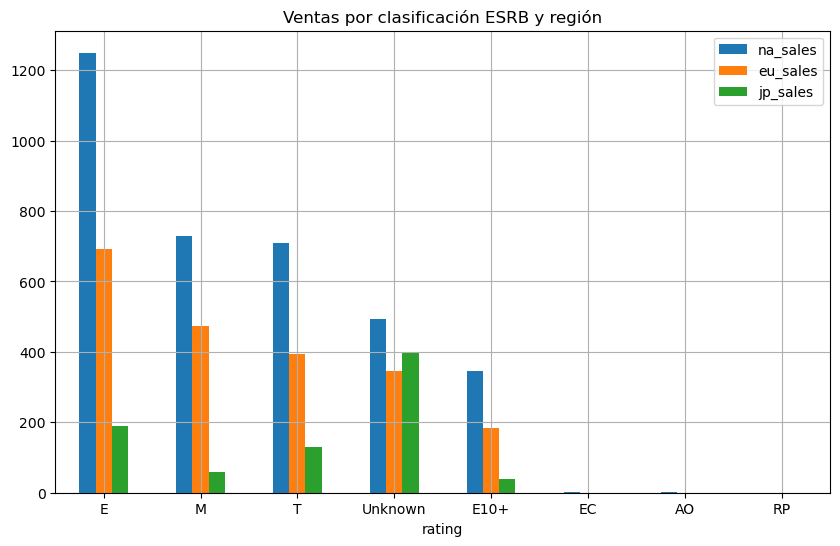

In [36]:
sales_by_rating.set_index('rating').plot(kind='bar', 
                                         figsize=(10,6), 
                                         title='Ventas por clasificación ESRB y región',
                                         rot=0,
                                         grid=True)
plt.show()

## 📝 Prueba de hipótesis

### Hipótesis 1

**Hipótesis nula:** Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

**Hipótesis alternativa:** Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.

In [37]:
xone_score = games[~(games['user_score'].isna()) & (games['platform'] == 'XOne')]
pc_score = games[~(games['user_score'].isna()) & (games['platform'] == 'PC')]

In [38]:
# Prueba las hipótesis
alpha = 0.05 # la significancia estadística crítica (umbral)
# realizar una prueba
results_score = st.ttest_ind(xone_score['user_score'], pc_score['user_score'],equal_var = False)
# imprimir el valor p resultante
print('P-Value: ', results_score.pvalue)
# comparar el valor p con el umbral
if (results_score.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

P-Value:  0.007073035808555002
Rechazamos la hipótesis nula


### Hipótesis 2

**Hipótesis nula:** Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son las mismas.

**Hipótesis alternativa:** Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [39]:
action_score = games[~(games['user_score'].isna()) & (games['genre'] == 'Action')]
sports_score = games[~(games['user_score'].isna()) & (games['genre'] == 'Sports')]

In [40]:
results_genre = st.ttest_ind(action_score['user_score'], sports_score['user_score'],equal_var = False)
# imprimir el valor p resultante
print('P-Value: ', results_genre.pvalue)
# comparar el valor p con el umbral
if (results_genre.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

P-Value:  1.8755843984029145e-13
Rechazamos la hipótesis nula


La hipótesis nula es aquella que formulada para verificar que no hubo ningún cambio, entre dos grupos de muestras estadísticas, por el contrario, la hipótesis alternativa es aquella que verifica la diferencia entre esas mismas dos muestras sin importar si fueron mayores o menores. Para las hipótesis dadas, la primera es considerada como hipótesis nula y la segunda es una hipótesis, solo fue cuestión de obtener sus hipótesis faltantes siguiendo el criterío marcado por las definiciones.

Por parte del criterio tomado para las pruebas de hipótesis, se tomó un alfa de 5%, además de ser un valor bastante común en las pruebas de hipótesis, es utilizado ya que asegur que la diferencia encontrada entre las muestras es lo suficientemente grande para no atribuir esas variaciones al azar.

## ✅ Conclusiones

Este proyecto a diferencia de los demás representó un reto mayor al dar la libertar de calcular cada una de las secciones de acuedo a lo aprendido en los sprints anteriores, si bien, es importante seguir una metodología definida para la resolución de los problemas no siempre se debe de tomar la misma ruta, uno de los grandes ejemplos se encontraron dentro de este proyecto, si bien gran mayoría del es muy similar, puesto que en gran medida se debe de agrupar, filtrar, modificar, agregar o eliminar información cada proyecto tiene objetivos y necesidades diferentes que dependen de lo que se quiere obtener del conjunto de datos a analizar. Una parte importante que hay que resaltar es que para hacer más eficiente la resolución de cada análisis es fundamental entender lo que se require, pues una buena compresión de lo solicitado generará los resultados deseados, las conclusiones correctas y lo más importante, el tiempo de resolución será menor. En perspectiva, muchos de los elementos vistos durante este proyecto serán de ayuda para futuros análisis, tanto en la parte de la codificación como en la parte de la interpretación, si bien es cierto que aún quedan cosas por aprender, cada vez será más sencillo el manejo de gran cantidad de información para su procesamiento.